In [1]:
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import model_helper

# Read the data
df = pd.read_csv('data.csv')

# Drop IDs
df.drop("id", axis=1, inplace=True)

# Drop final column with the NaN values
df.drop(df.columns[-1], axis=1, inplace=True)

df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
# Print dimensions of the data
df.shape

(569, 31)

In [3]:
training = df.sample(frac=0.8, random_state=25)
testing = df.drop(training.index)

In [4]:
# Print dimensions of the training data
training.shape

(455, 31)

In [5]:
# Print dimensions of the testing data
testing.shape

(114, 31)

In [6]:
# Plot label frequency for the data
def get_label_frequency(df, filename):
    frequency = df['diagnosis'].value_counts().plot(kind='bar')
    #frequency.set_ylim([0, 2000])
    for p in frequency.patches:
        frequency.annotate('{:1d}'.format(p.get_height()), (p.get_x()+0.17, p.get_height()+2))
    plt.subplots_adjust(bottom=0.2)
    plt.savefig(filename)

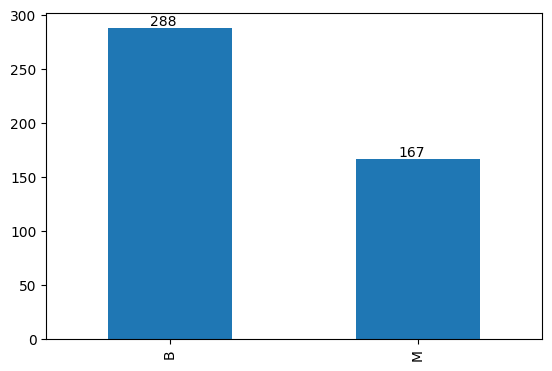

In [7]:
get_label_frequency(training, 'training_label_frequency.jpg')

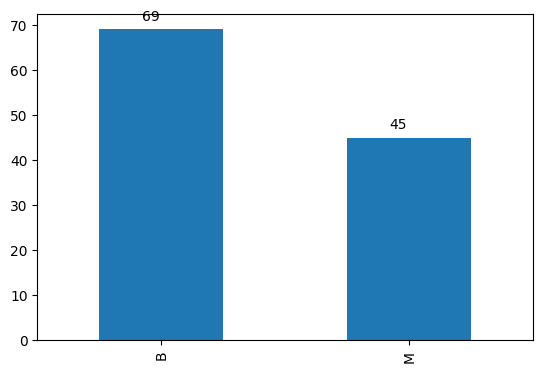

In [8]:
get_label_frequency(testing, 'testing_label_frequency.jpg')

In [9]:
# Encode the categorical variables
def encode(df):
    label_encoder = LabelEncoder()
    df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])
encode(training)
encode(testing)
training.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
522,0,11.26,19.83,71.30,388.1,0.08511,0.04413,0.005067,0.005664,0.1637,...,11.93,26.43,76.38,435.9,0.1108,0.07723,0.02533,0.02832,0.2557,0.07613
120,0,11.41,10.82,73.34,403.3,0.09373,0.06685,0.035120,0.026230,0.1667,...,12.82,15.97,83.74,510.5,0.1548,0.23900,0.21020,0.08958,0.3016,0.08523
241,0,12.42,15.04,78.61,476.5,0.07926,0.03393,0.010530,0.011080,0.1546,...,13.20,20.37,83.85,543.4,0.1037,0.07776,0.06243,0.04052,0.2901,0.06783
362,0,12.76,18.84,81.87,496.6,0.09676,0.07952,0.026880,0.017810,0.1759,...,13.75,25.99,87.82,579.7,0.1298,0.18390,0.12550,0.08312,0.2744,0.07238
221,0,13.56,13.90,88.59,561.3,0.10510,0.11920,0.078600,0.044510,0.1962,...,14.98,17.13,101.10,686.6,0.1376,0.26980,0.25770,0.09090,0.3065,0.08177


In [10]:
# Save testing data as csv
testing.to_csv("testing.csv", index=False)

In [11]:
# Split training and testing sets into explanatory data and labels (X and Y, respectively)
training_X = training.values[:, training.columns != "diagnosis"]
training_Y = training.values[:, training.columns == "diagnosis"]
testing_X = testing.values[:, testing.columns != "diagnosis"]
testing_Y = testing.values[:, testing.columns == "diagnosis"]

In [12]:
# Define model saving function
def save_model(filename, model):
    pickle.dump(model, open(filename, 'wb'))

In [13]:
# Train and save the Logistic Regression classifier
logisticRegressor = LogisticRegression()
logisticRegressor.fit(training_X, training_Y)
save_model("logisticRegressor.sav", logisticRegressor)

C:\Users\naran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\naran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
# Train and save the Naive Bayes classifier
naiveBayes = ComplementNB()
naiveBayes.fit(training_X, training_Y)
save_model("naiveBayes.sav", naiveBayes)

C:\Users\naran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
# Train and save the Random Forest classifier
randomForest = RandomForestClassifier()
randomForest.fit(training_X, training_Y)
save_model("randomForest.sav", randomForest)

C:\Users\naran\AppData\Local\Temp\ipykernel_37368\2626288813.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  randomForest.fit(training_X, training_Y)


In [16]:
# Train and save the Gradient Boosting Classifier
gradientBoostingMachine = GradientBoostingClassifier()
gradientBoostingMachine.fit(training_X, training_Y)
save_model("gradientBoostingMachine.sav", gradientBoostingMachine)

C:\Users\naran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
